# TIME SERIES FORECASTING FOR ENERGY CONSUMPTION

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()

In [2]:
df = pd.read_csv('archive/PJME_hourly.csv')

In [3]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


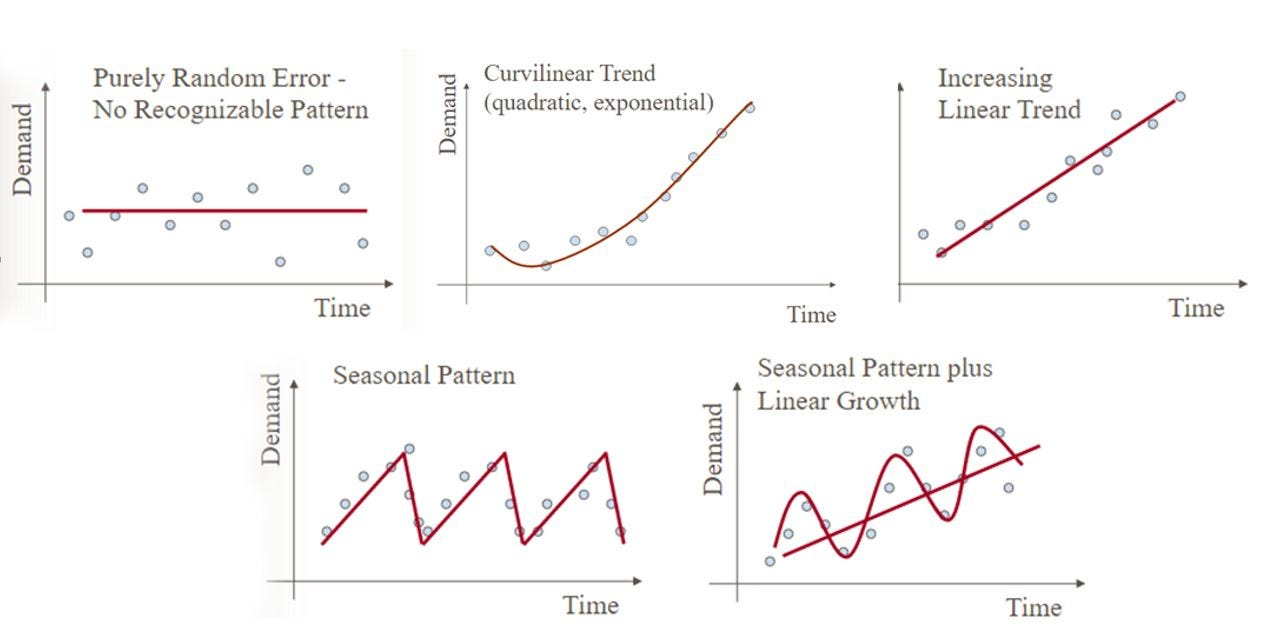

## Data Cleaning and Exploration

Since we are dealing with time series data, it is prefered to use the datetime column as the index for the dataframe

In [4]:
df.index = df['Datetime']
df.drop('Datetime',axis=1, inplace=True)

In [5]:
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


#### Checking Data Description

In [7]:
df.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


#### Checking for missing values in the data

In [8]:
df.isnull().sum()

PJME_MW    0
dtype: int64

As the above output indicates there seems to be no missing value in the data

#### Checking the distribution of the data

array([[<Axes: title={'center': 'PJME_MW'}>]], dtype=object)

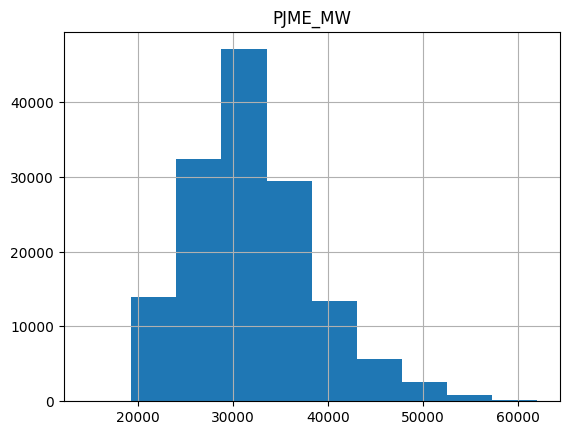

In [9]:
df.hist()

The above graph indicates that most of the values for the most case is distributed normally, i.e. data is not much skewed

#### Removing duplicate dates in the index

In [10]:
df = df[~df.index.duplicated(keep='first')]

In [11]:
print(df[df.index.duplicated(keep=False)])

Empty DataFrame
Columns: [PJME_MW]
Index: []


### Visualizing our Time Series Data

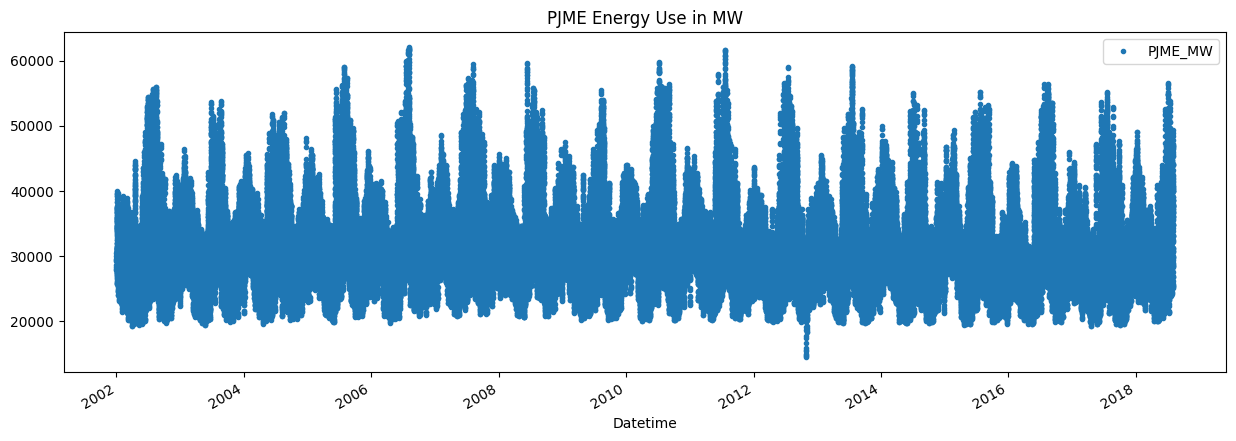

In [12]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

<hr>

## FEATURE ENGINEERING FOR TIME SERIES

### TRENDS
The trend element of a time series denotes a consistent and long-term shift in the average of the series. It is the component that evolves the slowest and reflects the most significant time scale. Consider a time series recording product sales, an upward trend could be attributed to a market expansion as the product gains more recognition and popularity with each passing year.

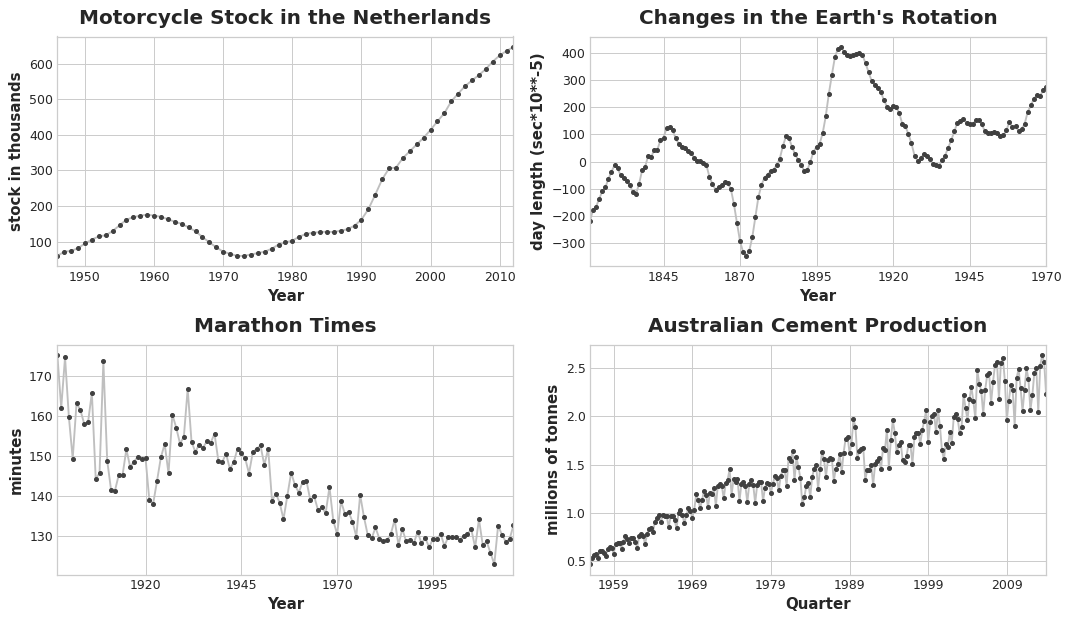

### Moving Average Plots

A moving average plot can be used to identify the trend of a time series. This involves computing the average of values within a sliding window of defined width. Each point on the graph is represented by the average of all values in the series within the window on either side. The purpose of this is to filter out short-term fluctuations in the series and to highlight only the long-term changes.

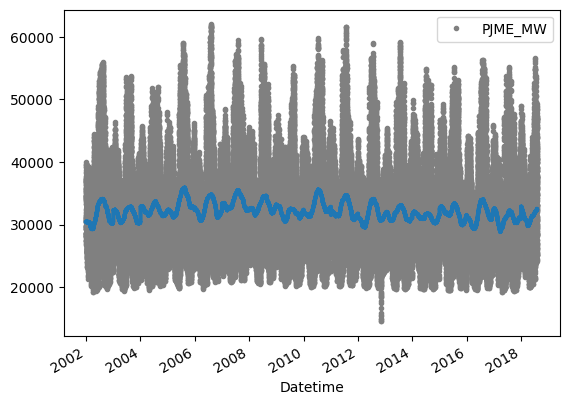

In [13]:
moving_average = df.rolling(
    window=365*10,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183*6,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = df.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="", legend=False,
);

Looking at the graph, it can be concluded that there is no significant trend obsereved in the data, so we will not be including that feature for anlaysis.

### Seasonality

When a time series displays a consistent, repetitive pattern in its mean, we refer to it as exhibiting seasonality. This regular pattern usually follows a fixed schedule, such as daily, weekly, or yearly, with cyclic variations that can be observed over specific intervals of time. Seasonality is commonly influenced by natural cycles, such as the changes in daylight and temperature over the course of a day or year, or by social customs and practices related to particular days or events.

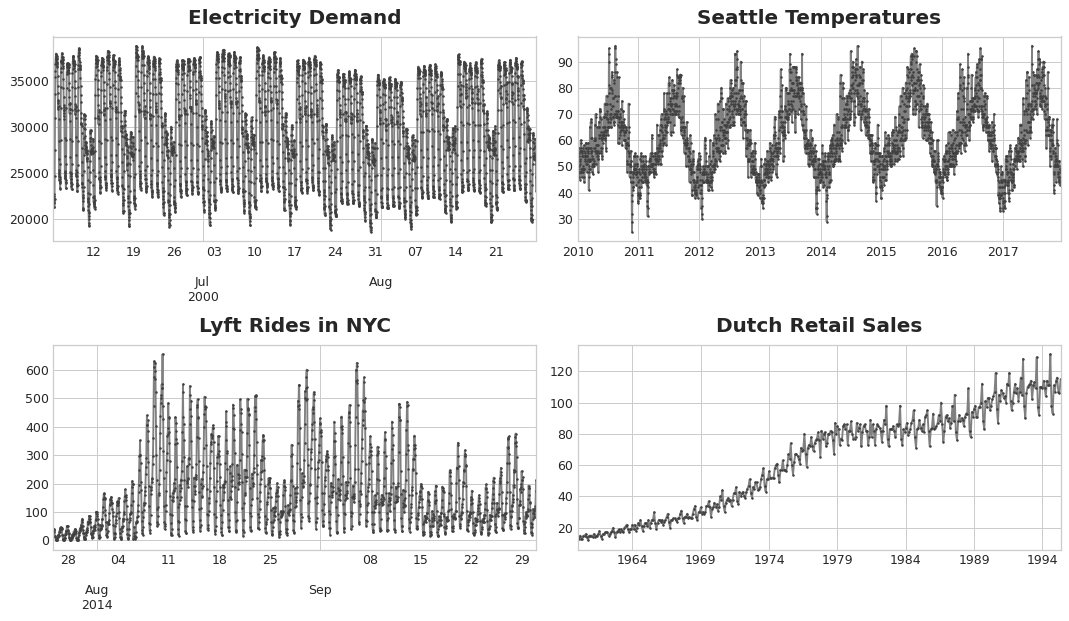

In [14]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    #ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

C:\Users\parik\AppData\Local\Temp\ipykernel_3224\3284806137.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
C:\Users\parik\AppData\Local\Temp\ipykernel_3224\3284806137.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

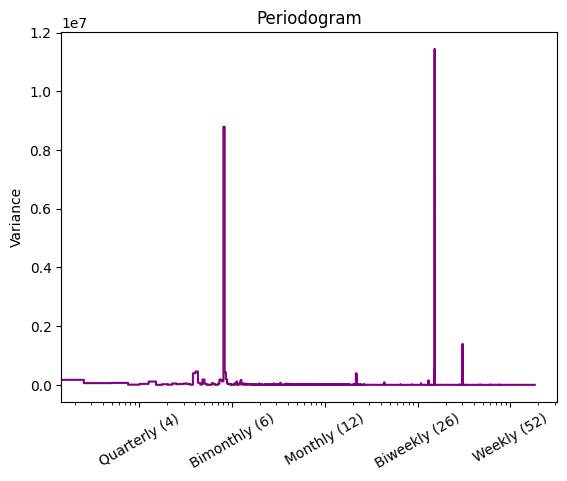

In [15]:
plot_periodogram(df['PJME_MW'])

The above periodogram indicates that there is definitely some seasonality in the data that needs to be captured. We are noticing sesonality in every week.

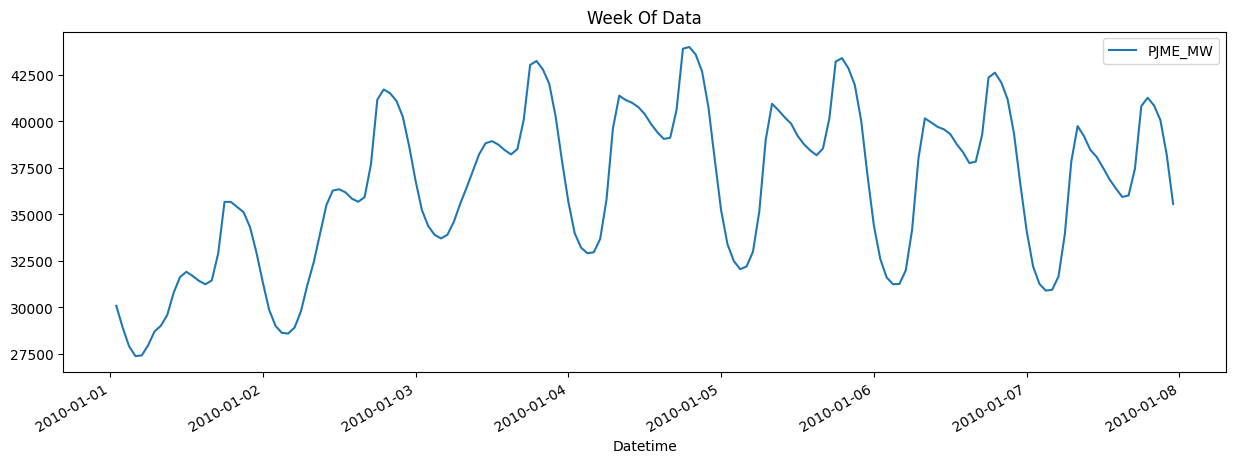

In [16]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [17]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [18]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


### Cylces

Serial dependence often appears in the form of cycles in time series analysis. Cycles are recurring patterns of growth and decline in a series that depend on previous values, but not necessarily on the time step itself. Cyclic behavior is typical of systems that have the ability to influence themselves or whose reactions persist over time. Economic trends, epidemics, animal populations, volcanic eruptions, and other natural phenomena are all examples of systems that can exhibit cyclic behavior.

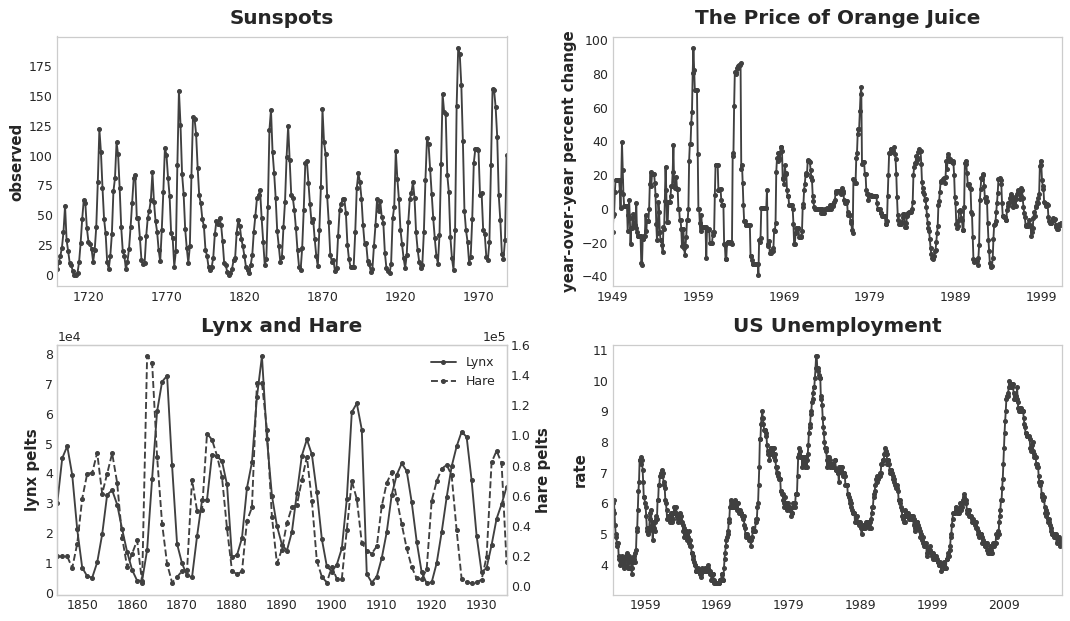

In [19]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [20]:
df = add_lags(df)

In [21]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1,30393.0,NaN,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1,29265.0,NaN,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1,28357.0,NaN,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1,27899.0,NaN,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1,28057.0,NaN,NaN


<hr>

## Train Test Split

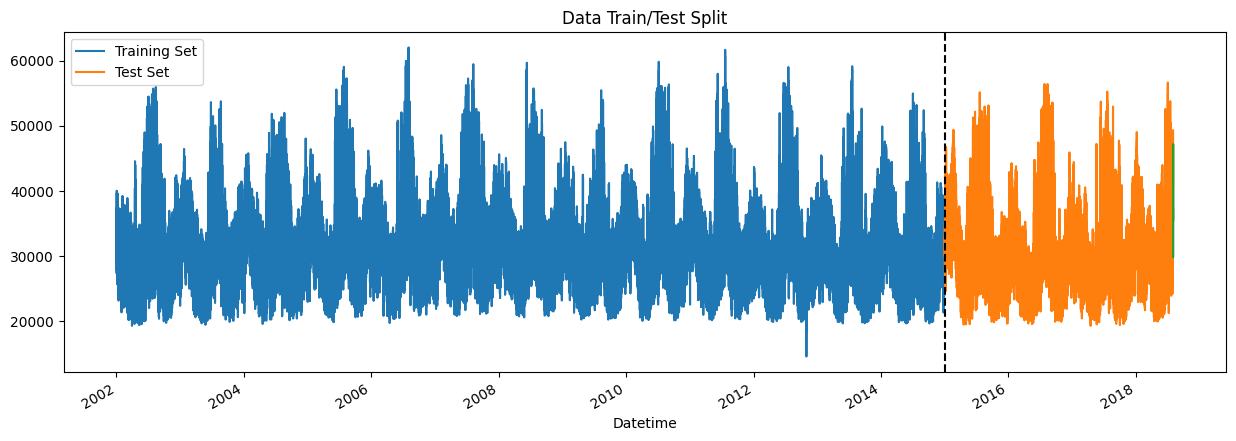

In [22]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[(df.index >= '01-01-2015') & (df.index<'2018-08-02')]
unseen = df.loc[df.index >= '2018-08-02']

fig, ax = plt.subplots(figsize=(15, 5))
train['PJME_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['PJME_MW'].plot(ax=ax, label='Test Set')
unseen['PJME_MW'].plot(ax=ax, label='Unseen Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Removing Outliers in the training data

Let us look at the distribution of values 

<Axes: >

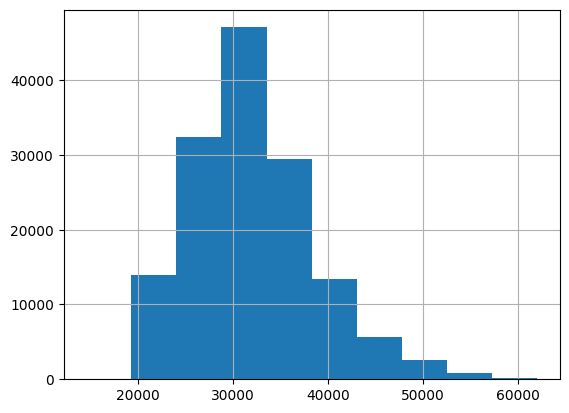

In [23]:
df['PJME_MW'].hist()

For the most part most values lie in the range of 20000 to 60000, but we can see that there are some values which are less than 20000, let us look at those values:

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

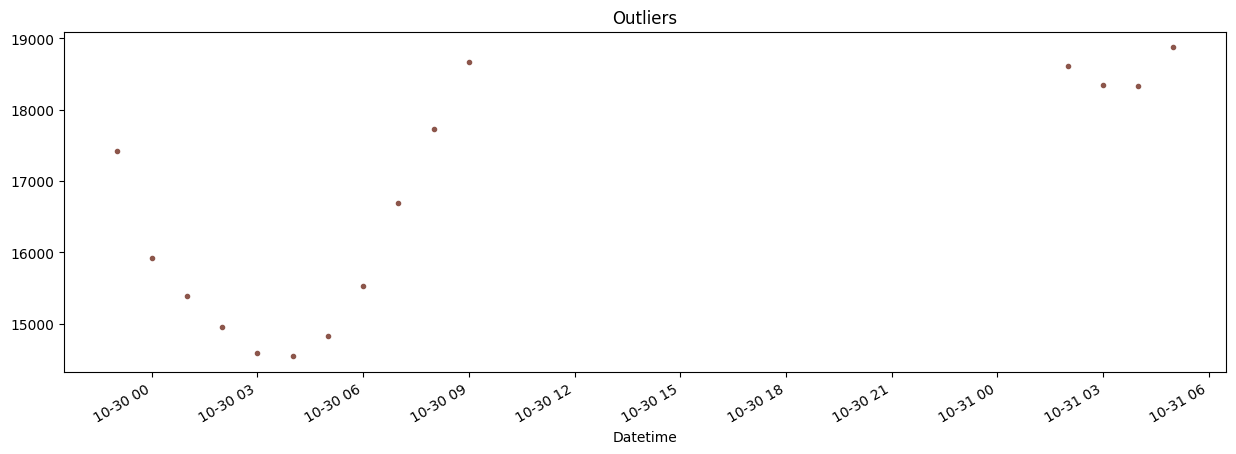

In [24]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

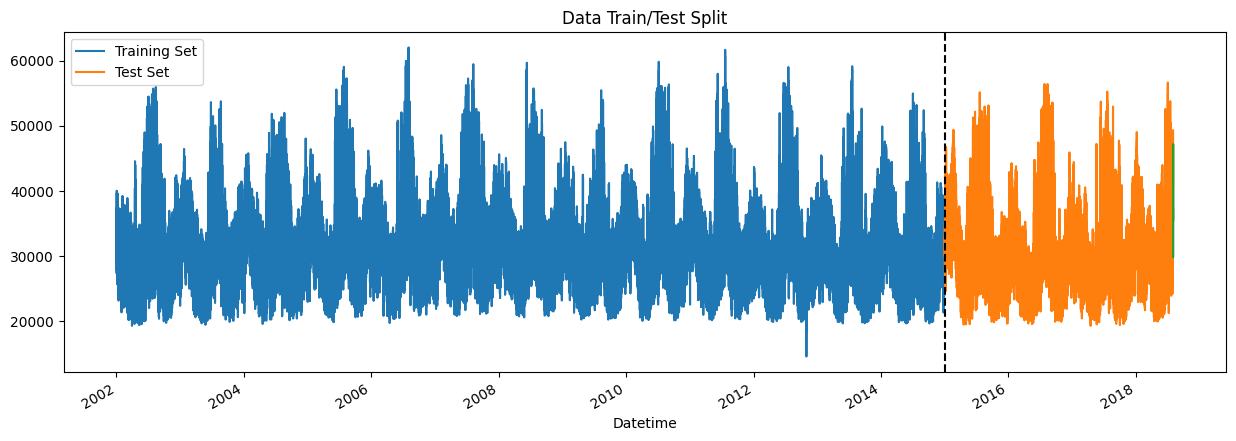

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
train['PJME_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['PJME_MW'].plot(ax=ax, label='Validation Set')
unseen['PJME_MW'].plot(ax=ax, label='Unseen Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

As the above figure once again indicates, the outliers have been removed for better modeling.

In [26]:
df = df.query('PJME_MW > 19_000').copy()

<hr>

## Cross Validation for the time series data

In [27]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

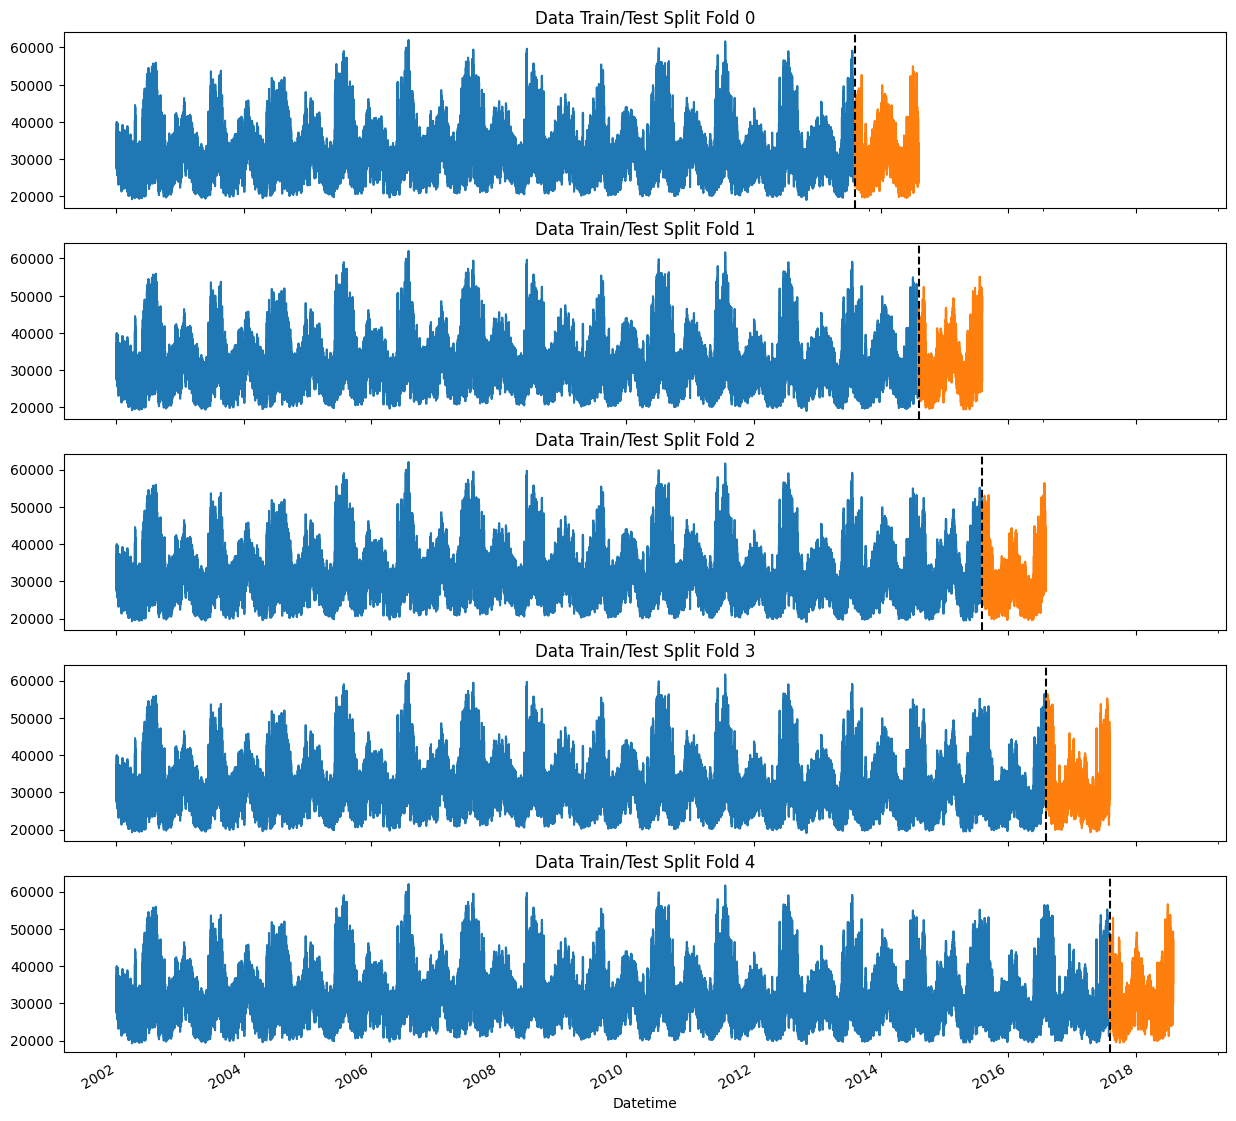

In [28]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

preds = []
scores = []
df_drop = df.dropna(axis=0)

poly = PolynomialFeatures(degree=2, include_bias=False)

for train_idx, val_idx in tss.split(df_drop):
    train = df_drop.iloc[train_idx]
    test = df_drop.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    X_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    lin = LinearRegression(n_jobs=-1)
    lin.fit(X_poly, y_train)
    
    y_pred = lin.predict(X_test_poly)
    
    preds.append(y_pred)

    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [30]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3974.8927
Fold scores:[3945.7265659736636, 3575.4891342133515, 3976.7221600596076, 4433.631540018308, 3942.8943286870076]


### XGB Regressor

In [31]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[05:59:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.22206	validation_1-rmse:31957.10388
[100]	validation_0-rmse:12532.05107	validation_1-rmse:11908.48922
[200]	validation_0-rmse:5745.59694	validation_1-rmse:5357.29757
[300]	validation_0-rmse:3869.48317	validation_1-rmse:3893.45260
[400]	validation_0-rmse:3431.60687	validation_1-rmse:3754.85945
[446]	validation_0-rmse:3361.93537	validation_1-rmse:3760.85733
[05:59:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.22016	validation_1-rmse:32136.53093
[100]	validation_0-rmse:12513.11711	validation_1-rmse:12221.27189
[200]	validation_0-rms

In [32]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3744.2243
Fold scores:[3753.874599779238, 3435.066310939607, 3478.888218354712, 4058.0739761055543, 3995.2182602371363]


#### Feature Importance

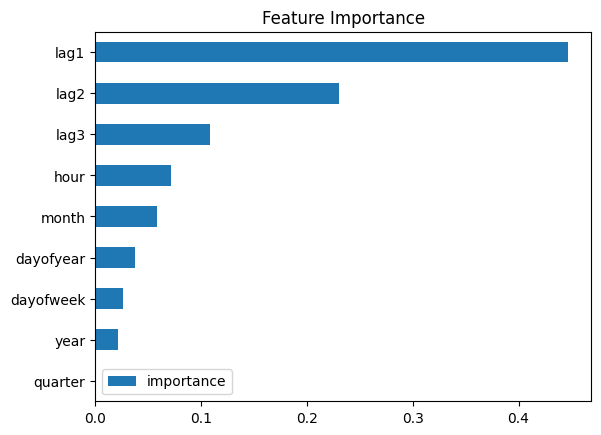

In [33]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

<hr>

## Random Forest Model

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

fold = 0
preds = []
scores = []
df_drop = df.dropna(axis=0)
for train_idx, val_idx in tss.split(df_drop):
    train = df_drop.iloc[train_idx]
    test = df_drop.iloc[val_idx]

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    rf = RandomForestRegressor(max_depth=3, n_estimators=1000)
    
    rf.fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

In [35]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3704.5605
Fold scores:[3615.409008475564, 3570.9750625504803, 3313.7978675675545, 4027.4898245021886, 3995.130634033563]


### Train the best model with all the data

In [36]:
df1 = df.loc[(df.index<'2018-08-02')]
unseen = df.loc[df.index >= '2018-08-02']

In [37]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_train = df1[FEATURES]
y_train = df1[TARGET]
    
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01,
                       verbose=100)
    
reg.fit(X_train, y_train)

[06:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[06:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### Predicting on unseen values

In [38]:
unseen['prediction'] = reg.predict(unseen[FEATURES])
df2 = df.merge(unseen['prediction'], how='left', left_index=True, right_index=True)

C:\Users\parik\AppData\Local\Temp\ipykernel_3224\219448309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen['prediction'] = reg.predict(unseen[FEATURES])


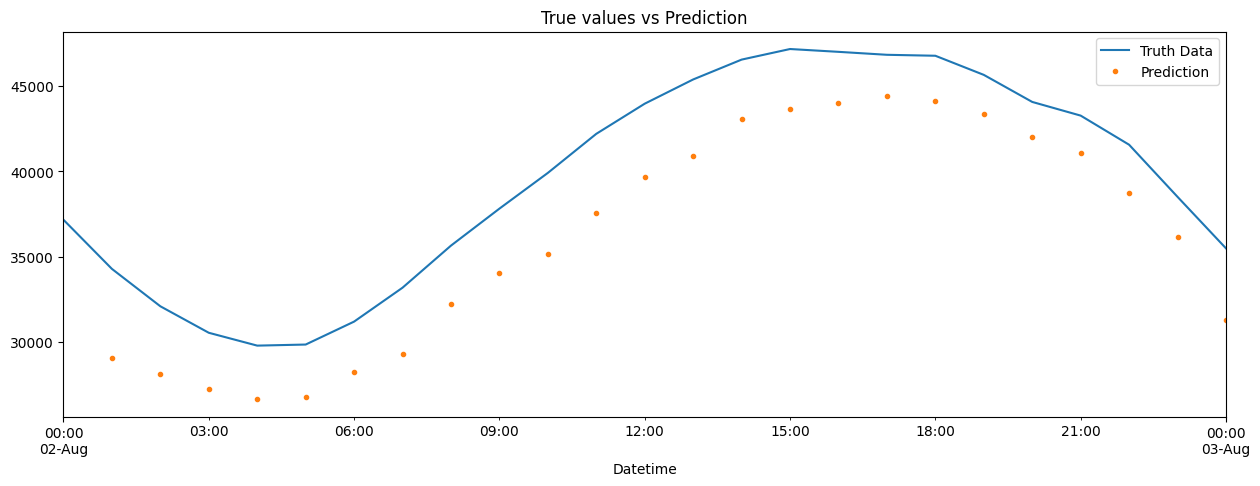

In [39]:
ax = df2.loc[(df2.index >= '2018-08-02')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='True values vs Prediction')
df2.loc[(df2.index > '2018-08-02')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [40]:
score = np.sqrt(mean_squared_error(df2.loc[(df2.index >= '2018-08-02')]['PJME_MW'], unseen['prediction']))

In [41]:
score

3718.7745010146173

As the above output indicates, the model has not overfit and is having a very good rmse score